<h2 align="center">BERT Language classifier, English and Luganda</h2>

In [2]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.8 MB/s 
     |████████████████████████████████| 462 kB 30.8 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset available in github repo</h4>

> Indented block



In [4]:
import pandas as pd

df = pd.read_csv("larger_vocab_en-lg.csv")
df.head(5)

,Text,Language
0,Abanoonyiboobubudamu bonna baasabiddwa beewand...,Luganda
1,Baayise olukungaana lw'abanoonyiboobubudamu eg...,Luganda
2,Abanoonyiboobubudamu b'abadde n'obutakkaanya w...,Luganda
3,Twakubirizibwa okwaniriza abanoonyiboobubudamu...,Luganda
4,Bwe tukolera awamu enkulaakulana enyingi efuni...,Luganda


In [5]:
df.groupby('Language').describe()

Text                                                               
          count unique                                                top freq
Language                                                                      
English   15022  15019  The water tank at home helps us reserve water ...    2
Luganda   15022  15000                  Abatemu beeyongedde ku muliraano.    2

In [6]:
df['Language'].value_counts()

Luganda    15022
English    15022
Name: Language, dtype: int64

**Handling imbalance**

In [7]:
df_spam = df[df['Language']=='Luganda']
df_spam.shape

(15022, 2)

In [8]:
df_ham = df[df['Language']=='English']
df_ham.shape

(15022, 2)

In [9]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(15022, 2)

In [10]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(30044, 2)

In [11]:
df_balanced['Language'].value_counts()

English    15022
Luganda    15022
Name: Language, dtype: int64

In [12]:
df_balanced['Luganda']=df_balanced['Language'].apply(lambda x: 1 if x=='Luganda' else 0)
df_balanced.sample(5)

,Text,Language,Luganda
22045,Venders shall only be allowed to operate if th...,English,0
7671,Okukuuma obukakkamu kya mugaso nnyo.,Luganda,1
13901,Amaka g'omukulu w'ekyalo ge gamu ku ago agatal...,Luganda,1
13515,Abakulembeze balina okulondoola emirimu okusob...,Luganda,1
6606,Obukulembeze kirooto kya buli muntu okuviira d...,Luganda,1


<h4>Split it into training and test data set</h4>

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Text'],df_balanced['Luganda'], stratify=df_balanced['Luganda'])

In [14]:
X_train.head(4)

13605    Abantu bali mu lugendo okujaguza n'okunyumirwa...
28988                          Why infrastructure matters?
1477     Mu bulimi bw'esimbi, abalimi batunda ebirime b...
11468    Kabonero ka kuwa kitiibwa okwebaza abantu abo ...
Name: Text, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "Abazira ennyo abaatusooka", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.89551973, -0.52823895, -0.72562164, ..., -0.6056532 ,
        -0.67844695,  0.8803997 ],
       [-0.8720836 , -0.50544   , -0.9444667 , ..., -0.8584748 ,
        -0.71745366,  0.88082993]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [17]:
e = get_sentence_embeding([
    "ennyo", 
    "Ameenvu",
    "mango",
    "jeff bezos",
    "milk",
    "bill gates"
]
)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[4]])

array([[0.95912576]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

<h4>Build Model</h4>

There are two types of models you can build in tensorflow. 

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [23]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [25]:
len(X_train)

22533

In [26]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [27]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
705/705 [==============================] - 505s 699ms/step - loss: 0.1710 - accuracy: 0.9576 - precision: 0.9491 - recall: 0.9672
Epoch 2/10
705/705 [==============================] - 489s 694ms/step - loss: 0.0426 - accuracy: 0.9933 - precision: 0.9962 - recall: 0.9902
Epoch 3/10
705/705 [==============================] - 489s 693ms/step - loss: 0.0228 - accuracy: 0.9967 - precision: 0.9985 - recall: 0.9949
Epoch 4/10
705/705 [==============================] - 487s 690ms/step - loss: 0.0142 - accuracy: 0.9984 - precision: 0.9994 - recall: 0.9975
Epoch 5/10
705/705 [==============================] - 487s 691ms/step - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9995 - recall: 0.9980
Epoch 6/10
705/705 [==============================] - 486s 690ms/step - loss: 0.0075 - accuracy: 0.9992 - precision: 0.9996 - recall: 0.9988
Epoch 7/10
705/705 [==============================] - 487s 691ms/step - loss: 0.0055 - accuracy: 0.9996 - precision: 0.9998 - recall: 0.9994
Epoch 8/10
70

In [28]:
model.evaluate(X_test, y_test)

235/235 [==============================] - 164s 687ms/step - loss: 0.0029 - accuracy: 0.9996 - precision: 1.0000 - recall: 0.9992


[0.002920249244198203, 0.9996005892753601, 1.0, 0.9992010593414307]

In [29]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [30]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 1, 1, 1])

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[3756,    0],
       [   3, 3752]])

Text(33.0, 0.5, 'Truth')

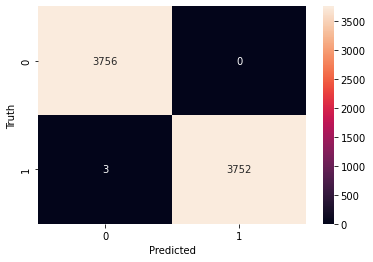

In [32]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3756
           1       1.00      1.00      1.00      3755

    accuracy                           1.00      7511
   macro avg       1.00      1.00      1.00      7511
weighted avg       1.00      1.00      1.00      7511



<h4>Inference</h4>

In [34]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.00071419],
       [0.05636467],
       [0.00464033],
       [0.0031188 ],
       [0.00079444]], dtype=float32)

In [35]:
model.predict(["Baalina muwala waabwe Bukirwa naye nga si mulungi mulwadde era nga bamufukako amazzi n’oganywa.	"])

array([[0.9991547]], dtype=float32)

In [37]:
model.predict(["Kiki ekikaza ebijanaalo?"])

array([[0.9997273]], dtype=float32)

In [38]:
import pickle

In [41]:
pickle.dump(model, open("bert_lang_detect_0Eng_1Lug_model.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://25eb6d95-284b-42e4-8abc-88379ec28694/assets


INFO:tensorflow:Assets written to: ram://25eb6d95-284b-42e4-8abc-88379ec28694/assets


In [42]:
model.predict(["Mpozzi erifuluma mu Januari 1946."])

array([[0.99681973]], dtype=float32)